In [1]:
import os
import numpy as np
import librosa
import noisereduce as nr
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\gabry\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
SAMPLE_RATE = 16000
N_MFCC = 13
N_MELS = 22
WINDOW = int(SAMPLE_RATE * 0.01)
HOP = int(SAMPLE_RATE * 0.005)
max_timesteps = 930

In [3]:
# Classes
labels = ['baca', 'berhenti', 'foto', 'halo', 'info', 'kembali', 'ulang']

In [4]:
# Load model
model = load_model('model/mymodeld.h5')

In [5]:
# # Preprocessing function
# def preprocess_audio(file_path):
#     y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
#     y = y / np.max(np.abs(y))  # Normalize

#     # Wavelet Packet Decomposition
#     wp = pywt.WaveletPacket(y, wavelet='db4', mode='symmetric', maxlevel=3)
#     wp_coeff = np.concatenate([node.data for node in wp.get_level(3, 'freq')])

#     # MFCC Extraction
#     mfcc = librosa.feature.mfcc(y=wp_coeff, sr=SAMPLE_RATE, n_mfcc=N_MFCC,
#                                  n_mels=N_MELS, n_fft=WINDOW, hop_length=HOP).T

#     # Padding
#     padded = pad_sequences([mfcc], padding='post', dtype='float32', maxlen=max_timesteps)
#     return padded

def preprocess_audio(file_path):
    # Load audio
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Reduce noise
    y = nr.reduce_noise(y=y, sr=sr)

    # Normalize
    y = y / np.max(np.abs(y))

    # Wavelet Packet Decomposition
    wp = pywt.WaveletPacket(y, wavelet='db4', mode='symmetric', maxlevel=3)
    wp_coeff = np.concatenate([node.data for node in wp.get_level(3, 'freq')])

    # MFCC Extraction
    mfcc = librosa.feature.mfcc(y=wp_coeff, sr=sr, n_mfcc=N_MFCC,
                                n_mels=N_MELS, n_fft=WINDOW, hop_length=HOP).T

    # Padding
    padded = pad_sequences([mfcc], padding='post', dtype='float32', maxlen=max_timesteps)
    return padded

In [6]:
# Evaluation
y_true = []
y_pred = []

In [7]:
# Folder datasetuji/<label>/*
dataset_path = 'datasetuji'

for label in labels:
    folder_path = os.path.join(dataset_path, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)

            # Preprocess and predict
            x_input = preprocess_audio(file_path)
            prediction = model.predict(x_input)
            pred_label_idx = np.argmax(prediction)

            y_true.append(labels.index(label))
            y_pred.append(pred_label_idx)

1/1 [==============================] - 0s 103ms/step


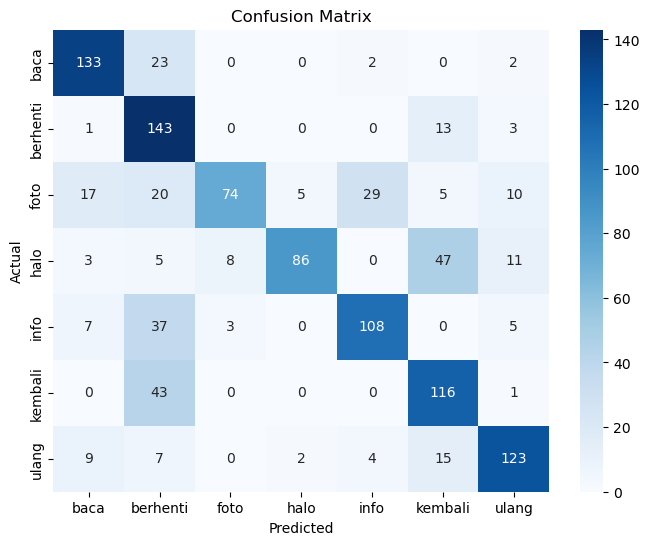

              precision    recall  f1-score   support

        baca       0.78      0.83      0.81       160
    berhenti       0.51      0.89      0.65       160
        foto       0.87      0.46      0.60       160
        halo       0.92      0.54      0.68       160
        info       0.76      0.68      0.71       160
     kembali       0.59      0.72      0.65       160
       ulang       0.79      0.77      0.78       160

    accuracy                           0.70      1120
   macro avg       0.75      0.70      0.70      1120
weighted avg       0.75      0.70      0.70      1120



In [8]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels)
print(report)

C:\Users\gabry\AppData\Local\Temp\ipykernel_9940\1623139041.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracy_per_label, palette='viridis')


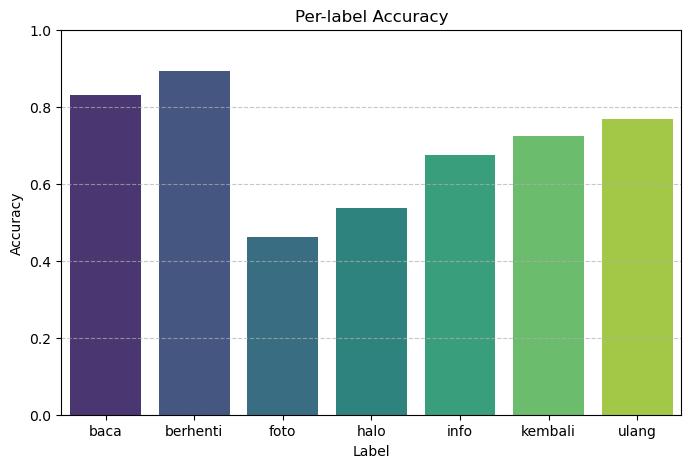

In [9]:
# Akurasi per Label
correct_per_label = np.diag(cm)  # Benar (diagonal matrix)
total_per_label = np.sum(cm, axis=1)  # Total sample per label

accuracy_per_label = correct_per_label / total_per_label

# Bar Chart Akurasi per Label
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=accuracy_per_label, palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title('Per-label Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
